# Adaptive Stochastic Gradient Descent

Implementation and comparison of adaptive stochastic gradient descent methods using Python programming language. The efficiency comparison is demonstrated in the logistic regression optimization problem.

## Introduction

**Gradient descent** is one of the most popular numerical methods for solving modern optimization problems: from cost reduction to neural networks training. The thing that all these problems have in common is an aim to describe it as a mathematical model (e.g. mathematical equation) $J(\theta_{i})$, which has a set of independent parameters $\theta_{i}$, and then find specific values of $\theta_{i}$ so $J(\theta_{i})$ will reach the minimum possible value. As an example, in neural network training $J(\theta_{i})$ can be described as a loss between the expected training example and the actual one, where $\theta_{i}$ will be the **weight coefficients** of the neural network. So the goal of the training process is to find the optimal value of **weight coefficients**, so the loss will become minimum and the output value of a neural network will become as close to expected as possible.

By definition, the **gradient** is a vector that points towards the highest  increase of the function value $F$ in high dimensional space $R^{n}$, that can be interpreted as a vector of partial derivatives with respect to each parameter $x_{1}, ..., x_{n}$ of the function $F$ in the specific point $a$:

$\nabla F(a) = \begin{bmatrix}
\frac{\partial f}{\partial x_{1}} (a) \\
\vdots \\
\frac{\partial f}{\partial x_{n}} (a) \\
\end{bmatrix}$

Various optimization algorithms, which are based on **gradient descent**, have common feature: usage of a vector, opposite to the gradient value (antigradient or $- \nabla F$), as the key direction to the function minimum.

### Overviewed algorithms

- SGD
- Dynamic Sampling SGD
- Mini-batch SGD
- Nesterov AG
- ADAGRAD
- RMSPROP
- ADAM

### Tensorflow API usage

**Gradient values** calculation will be speeded up for overviewed methods using [computation graphs](https://www.tensorflow.org/api_docs/python/tf/Graph) from [TensorFlow framework API](https://github.com/tensorflow/tensorflow).

In [1]:
import tensorflow as tf

Tensorflow framework provides class [tf.GradientTape()](https://www.tensorflow.org/api_docs/python/tf/GradientTape) with a set of methods for required computations: [gradient()](https://www.tensorflow.org/api_docs/python/tf/GradientTape#gradient) and [jacobian()](https://www.tensorflow.org/api_docs/python/tf/GradientTape#jacobian). The following section contains examples of gradient computations:

In [2]:
# Defining the scope of gradient computation. Here all defined variables
# will be registered in Tensorflow calculation graph.
with tf.GradientTape(persistent=True) as grad:
  x, y = (tf.Variable(2.0), tf.Variable(-1.0))

  # Single variable equation
  f = x ** 3 + 2 * x ** 2 + 12 * x + 100

  # Multiple variable equation
  F = x ** 2 + x * y + y ** 2

# f'(x) = 3 * x ** 2 + 4 * x + 12, f'(2.0) = 32.0
df = grad.gradient(f, x)

# dFdx = 2 * x + y, dFdx(2.0, -1.0) = 3.0
# dFdy = x + 2 * y, dFdy(2.0, -1.0) = 0.0
[dFdx, dFdy] = grad.gradient(F, [x, y])

# Release graph allocated memory
del grad

print(f'Single variable equation:\nf\'(2.0) = {df};\n')
print(f'Multiple variable equation:\ndFdx(2.0, -1.0) = {dFdx};\ndFdy(2.0, -1.0) = {dFdy};')

Single variable equation:
f'(2.0) = 32.0;

Multiple variable equation:
dFdx(2.0, -1.0) = 3.0;
dFdy(2.0, -1.0) = 0.0;


### Tensor operations

All tensor-like structure wrappers and operation methods for them are used from [Numpy](https://github.com/numpy/numpy) package.

In [3]:
import numpy as np

### Algorithm convergence visualisation

Iterations of the each **gradient descent** algorithm can be plotted as the path on 3D surface, in case model has only 2 independent parameters $\{ \theta_{1}, \theta_{2} \}$ so they can represent $X$ and $Y$ axises, and remaining $Z$ axis represents value of estimation equation to optimize $J(\theta_{1}, \theta_{2})$. All visualisation tools are used from [matplotlib](https://github.com/matplotlib/matplotlib) package.

In [4]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid
import matplotlib.cm as colormaps

Useful plotting functions

In [5]:
from typing import Callable


def plot_grid(F: Callable[[np.array, np.array], np.array],
              X: np.array, Y: np.array,
              elev=30, azim=50, ax=None):
  """
  Plots 3D surface grid for 2 independent
  parameters and estimation equation
  :param F: estimation equation
  :param X: first independent parameter
  :param Y: second independent parameter
  :param elev: vertical rotation angle
  :param azim: horizontal rotation angle
  :param ax: predefined plotting axis
  :return: generated plotting axis
  """

  # Generating grid
  x, y = np.meshgrid(X, Y)

  # If grid plotting axis is not defined above,
  # the new one will be created
  if ax is None:
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.view_init(elev=elev, azim=azim)

  # Plotting grid
  surf = ax.plot_surface(x, y, F(x, y), 
                         cmap=colormaps.coolwarm, 
                         antialiased=True)
  fig.colorbar(surf)

  # For axis reusability purposes
  return ax

### Optimization problem

**Logistic regression** is chosen as an example of an optimization problem for comparing the convergence rate of the **gradient descent** algorithms. This mathematical model can be described as a binary classifier, which outputs a probability value of a certain set of features $x_{i}$ to belong to a certain class (e. g. **true** or **false**). Using the definition of optimization problem from above, the classifier can be represented in the form of two components: **an adder** that combines all the characteristics into a single one: $z_{j} = \sum_{i=1}^{n} \theta_{i} x_{i, j}$ (or $z_{j} = \theta^{T} \cdot x$), and **a converter** that calculates the probability of the characteristics belonging to a certain class based on the output value of **an adder**: $g(a) = \frac{1}{1 + e^{-a}}$.

In [6]:
# Adder component
Z = lambda theta, x: tf.transpose(theta) @ x

# Converter component
G = lambda a: tf.reshape(1.0 / (1.0 + tf.exp(-a)), shape=())

Classification test cases

In [7]:
# x = (0, 0), theta = (1, 1) => g = 0.5
tf.assert_equal(G(Z(tf.constant([[1.0], [1.0]]),
                    tf.constant([[0.0], [0.0]]))),
                tf.constant(0.5))

# x = (1, 0), theta = (1, 1) => g = 0.7310586
tf.assert_equal(G(Z(tf.constant([[1.0], [1.0]]),
                    tf.constant([[1.0], [0.0]]))),
                tf.constant(0.7310586))

# x = (0, -1), theta = (1, 1) => g = 0.26894143
tf.assert_equal(G(Z(tf.constant([[1.0], [1.0]]),
                    tf.constant([[0.0], [-1.0]]))),
                tf.constant(0.26894143))

# x = (0.5, -1), theta = (2, -1.5) => g = 0.9241418
tf.assert_equal(G(Z(tf.constant([[2.0], [-1.5]]),
                    tf.constant([[0.5], [-1.0]]))),
                tf.constant(0.9241418))

The solution to the problem is to find optimal $\theta_{i}$ so for input features $x_{i}$ the **loss** $J(\theta_{i})$ between output value of classifier $\hat{y_{j}} = g(z_{\theta}(x_{i, j}))$ and expected value $y_{j}$ will be minimal.

The set of classes, mentioned above, can be represented as $\{ 0, 1 \}$, e. g. if model output is $1$ - features belong to the class, and if $0$ - features do not belong to the class. In this case, the rule of the fitting regression model can be interpreted as follows: *if expected output is $y=1$, the loss should approach $0$ when model output approaches $1$ and grow to infinity when model output approaches $0$. For the case $y=0$ these conditions apply vise versa.*

Model fitting rule or **loss function** can expressed as limits:

$\begin{cases}
\lim_{g(z_{\theta}(x_{i, j})) \to 1} J_{j}(\theta_{i}) = 0 & \& & \lim_{g(z_{\theta}(x_{i, j})) \to 0} J_{j}(\theta_{i}) = \infty, & y=1 \\
\lim_{g(z_{\theta}(x_{i, j})) \to 0} J_{j}(\theta_{i}) = 0 & \& & \lim_{g(z_{\theta}(x_{i, j})) \to 1} J_{j}(\theta_{i}) = \infty, & y=0
\end{cases}$

Limitation conditions fit the $\log(x)$ function, so the **loss function** can be expressed as the following system:

$ J_{j}(g, y) = \begin{cases}
-\log(g), & y = 1  \\
-\log(1 - g), & y = 0
\end{cases}$

The statement can be joined into a single formula: $ J_{j}(g, y) = - y \log(g) - (1 - y) \log(1 - g) $ - this formula is appliable for single pair of features and output. For multiple pairs loss value can be calculated as the mean of losses for single pairs: $ J(g, y) = \frac{1}{m} \sum_{j=1}^{m} J_{j}(g, y) = \frac{1}{m} \sum_{j=1}^{m} ( - y \log(g) - (1 - y) \log(1 - g) ) = -\frac{1}{m} \sum_{j=1}^{m} (y \log(g) + (1 - y) \log(1 - g) )$

In [8]:
# Loss function
J = lambda g, y: - y * tf.math.log(g) - (1 - y) * tf.math.log(1 - g)

As the result, the derived fitting rule (**loss function**) is a convex function with only one minimum: **the global minimum**. This can be demonstraited on the following plots:

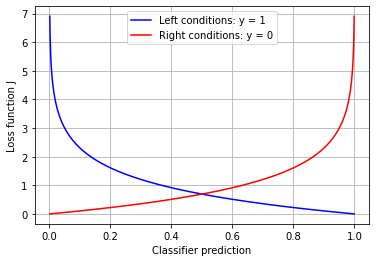

In [9]:
g = np.arange(0.001, 1.0, 0.001)

JLeft = -np.log(g)
JRight = -np.log(1 - g)

plt.plot(g, JLeft, 'b-', label='Left conditions: y = 1')
plt.plot(g, JRight, 'r-', label='Right conditions: y = 0')
plt.xlabel('Classifier prediction')
plt.ylabel('Loss function J')
plt.grid(True)
plt.legend(loc='upper center')

plt.show()

The **loss** function is formed from combined limit conditions, which is plotted as a diagonal cross-section of the grid below:

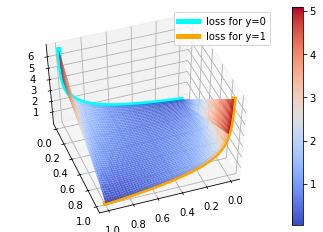

In [10]:
y = np.arange(0.001, 1.0, 0.001)

# Arguments for output equals 0
yleft = np.zeros(y.shape[0])

# Arguments for output equals 1
yright = np.ones(y.shape[0])

# Loss function
j = lambda G, Y: - Y * np.log(G) - (1 - Y) * np.log(1 - G)

# Loss function plot in 3D cross-section
ax = plot_grid(j, g, y, elev=50, azim=70)

# Loss function plot for output equals 0
ax.plot(g, yleft, j(g, yleft),
        lw=5, color='cyan', label="loss for y=0")

# Loss function plot for output equals 1
ax.plot(g, yright, j(g, yright),
        lw=5, color='orange', label="loss for y=1")

plt.legend()
plt.show()

Loss calculation test cases

In [11]:
np.testing.assert_almost_equal(
    J(tf.constant(0.0001), tf.constant(0.0)).numpy(),
    0.00010002)

np.testing.assert_almost_equal(
    J(tf.constant(0.9998), tf.constant(1.0)).numpy(),
    0.00019999)

np.testing.assert_almost_equal(
    J(tf.constant(0.8), tf.constant(0.0)).numpy(),
    1.609438)

np.testing.assert_almost_equal(
    J(tf.constant(0.2), tf.constant(1.0)).numpy(),
    1.609438)

### Training dataset

Necessary requirements for a set of training examples are:
- Expected outputs should belong only to binary classes, e. g. $\hat{y_{j}} \in \{ 0, 1 \}$;
- Input features should be defined as rational values $ \{ x_{ij} | x_{ij} \in R \} $;

For simplicity, a set of a training examples will be generated as feed-forward of regression model $g(z_{\theta}(\hat{\theta_{i}}, x_{i, j}))$, where $ \hat{\theta_{i}} $ - predefined parameters, with applied **normaly distributed** random noise $\varepsilon \simeq N(0, 0.1)$

In [12]:
# To generate same random numbers per each run.
# Random seed definition is required for testing
# purposes, it can be commented out in experimental
# mode.
np.random.seed(0)

# Mean, variance and count of training exmaples
mu, sigma, n = 0, 0.1, 1000

# Random noise
e = np.random.normal(mu, sigma, n)

# Predefined parameters
theta = np.array([4.0, 2.0])

# Input features
x = np.vstack((e, e))

# Output labels
y_ = 1.0 / (1.0 + np.exp(-(theta.T @ x)))

# Expected output labels
y = np.rint(y_)

## Gradient descent variations

**Gradient descent** algorithms have a common feature: using calculated gradient value as a direction towards the minimum of the function. The **gradient** value, by definition, is a **vector** that points towards the direction of **the greatest increase of the function** in a specific point. So the value, opposite to the gradient value or $ - \nabla_{\theta} J $, points towards the minimum.

In general, **gradient descent** algorithm can be expressed as an iterative algorithm, that on each step $ \theta_{j}^{(i)} $ moves in direction of $ - \nabla_{\theta} J $ with a fixed size step $ \lambda $ (also known as learning rate) untill it reaches the minimum: $\theta_{j}^{(i+1)} = \theta_{j}^{(i)} - \lambda \nabla_{\theta} J$.

Depending on how much data is used to compute the gradient of objective function, general form of an algorithm can variate, which leads to the possibility for a trade-off between the accuracy of the parameter update and the time it takes to perform an update.

### Batch gradient descent

**Batch gradient descent** or **vanilla gradient descent** performs computation of the gradient for $ \nabla_{\theta} J $ with respect to the independent variables $ \theta_{j} $ for the entire set of training examples: $\theta^{(i+1)} = \theta^{(i)} - \lambda \nabla_{\theta} J(\theta, x, y)$

Although **batch gradient descent** is guaranteed to converge to the global
minimum for convex noisy surfaces, it requires to calculate gradient value for the entire set training examples, which makes it unefficient to calculate in parallel and, as the result, makes it **very slow**, because it **can not update** model parameters **"on-the-fly"**. Another issue with this algorithm is an eager usage of memory, which means loading every training example into memory.

**Vanilla GD** performs redundant computations for large datasets, as it recomputes gradients for similar examples before each parameter update, so its usage is efficient on a relatively small datasets.

### Stochastic gradient descent

Unlike algorithm from above, **stochastic gradient descent** (SGD) calculates gradient and performs parameters update **for a single training example** at once $( x_{i1}, ..., x_{in}, y_{i} ) $, where $ x_{i1}, ..., x_{in} $ are input features of a training example and $ y_{i} $ - label a training example: $\theta^{(i+1)} = \theta^{(i)} - \lambda \nabla_{\theta} J(\theta_{1}^{(i)}, ..., \theta_{n}^{(i)}, x_{1}^{(i)}, ..., x_{n}^{(i)}, y^{(i)})$

SGD removes redundancy for recomputing gradients for similar examples before each parameter update and also provides a possibility for a parallel computation of the gradient value for each example, which leads to updating model parameters **"on-the-fly"** (which lead to the faster computation).

Nevertheless, this approach has its own flaw: **frequent updates** with a high variance that cause the objective function to **fluctuate heavily**. On the one hand, SGD’s fluctuation enables it to jump to a new and potentially better (global) minimum in a process of descending to the other local minimum. But on the other hand, this ultimately complicates convergence to the exact minimum, as SGD will keep overshooting. In practice, this flaw can be solved using **learning rate decay methods** (e. g. rate decreasing over epoch/iteration), though it requires precise parameter tuning.

## Attribution

Overview is based on research paper "An overview of gradient descent optimization algorithms" from [arXiv.org](https://arxiv.org/pdf/1609.04747.pdf) by [Sebastian Ruder](mailto:ruder.sebastian@gmail.com) licensed under CC BY-NC-SA 4.0.